In [3]:
# ライブラリをインポート

# データ操作と数値計算のため
import pandas as pd
import numpy as np

# データ可視化のため
import matplotlib.pyplot as plt
import seaborn as sns

# 統計モデリングと計量経済分析のため
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

# for ignore warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
url = "https://www.fbc.keio.ac.jp/~tyabu/keiryo/oil_data.csv"
df = pd.read_csv(url)
date_range = pd.date_range(
    start='1987-06-01',
    end='2017-12-31',
    freq='M' # 月次
)

df['date'] = date_range
df.head()

,date,price,brent,spot
0,1987-06-30,59.9,18.86,144.55
1,1987-07-31,59.9,19.86,150.29
2,1987-08-31,59.9,18.98,147.33
3,1987-09-30,59.9,18.31,143.29
4,1987-10-31,59.9,18.76,143.32


## 変数の定義

In [5]:
df['oil'] = df['brent'] * df['spot']
df['log_price'] = np.log(df['price'])
df['y'] = 100 * df['log_price'].diff()
df['log_oil'] = np.log(df['oil'])
df['x'] = 100 * df['log_oil'].diff()
df['x_lag1'] = df['x'].shift(1)
df['x_lag2'] = df['x'].shift(2)
df['dx'] = df['x'] - df['x_lag1']
df['dx_lag'] = df['dx'].shift(1)
df['d1'] = ((df['date'].dt.year == 2008) & (df['date'].dt.month == 4)).astype(int) # 暫定税率の影響を除くための一時的ダミー
df['d2'] = ((df['date'].dt.year == 2008) & (df['date'].dt.month == 5)).astype(int) # 暫定税率の影響を除くための一時的ダミー

# 6.4.1節の推定
2000年1月以降のデータを用いて推定する

In [6]:
df_post_2000 = df[df['date'] >= '2000-01-01'].copy()
df_post_2000 = df_post_2000.reset_index(drop=True)
df_post_2000.head()

,date,price,brent,spot,oil,log_price,y,log_oil,x,x_lag1,x_lag2,dx,dx_lag,d1,d2
0,2000-01-31,63.1,25.51,105.30,2686.2030,4.144721,0.795549,7.895884,2.773968,1.558972,9.835606,1.214996,-8.276635,0,0
1,2000-02-29,63.3,27.78,109.39,3038.8542,4.147885,0.316456,8.019236,12.335186,2.773968,1.558972,9.561218,1.214996,0,0
2,2000-03-31,64.3,27.49,106.31,2922.4619,4.163560,1.567430,7.980182,-3.905416,12.335186,2.773968,-16.240602,9.561218,0,0
3,2000-04-30,64.5,22.76,105.63,2404.1388,4.166665,0.310559,7.784947,-19.523463,-3.905416,12.335186,-15.618047,-16.240602,0,0
4,2000-05-31,63.5,27.74,108.32,3004.7968,4.151040,-1.562532,8.007965,22.301819,-19.523463,-3.905416,41.825282,-15.618047,0,0


In [7]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

mod_1 = sm.OLS(
  endog,
  exog
)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     170.0
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           8.69e-72
Time:                        12:46:02   Log-Likelihood:                -411.42
No. Observations:                 216   AIC:                             834.8
Df Residuals:                     210   BIC:                             855.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0577      0.113      0.511      0.6

# 累積効果を推定する簡単な方法(練習問題参照)

In [8]:
endog = df_post_2000['y']
exog = df_post_2000[['dx', 'dx_lag', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

mod_2 = sm.OLS(
  endog,
  exog
)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     170.0
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           8.69e-72
Time:                        12:46:34   Log-Likelihood:                -411.42
No. Observations:                 216   AIC:                             834.8
Df Residuals:                     210   BIC:                             855.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0577      0.113      0.511      0.6

# AICとBICを計算する
p=0, 1, 2の場合

In [9]:
# p = 0 の場合
endog = df_post_2000['y']
exog = df_post_2000[['x', 'd1', 'd2']]
exog = sm.add_constant(exog)
mod_p0 = sm.OLS(
  endog,
  exog
)
res_p0 = mod_p0.fit()
aic = res_p0.aic
bic = res_p0.bic
print("AIC:", aic)
print("BIC:", bic)

AIC: 1022.5028783239172
BIC: 1036.0039919546539


In [10]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'd1', 'd2']]
exog = sm.add_constant(exog)
mod_p0 = sm.OLS(
  endog,
  exog
)
res_p0 = mod_p0.fit()
aic = res_p0.aic
bic = res_p0.bic
print("AIC:", aic)
print("BIC:", bic)

AIC: 1022.5028783239172
BIC: 1036.0039919546539


In [11]:
# p = 1 の場合
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'd1', 'd2']]
exog = sm.add_constant(exog)
mod_p1 = sm.OLS(
  endog,
  exog
)
res_p1 = mod_p1.fit()
aic = res_p1.aic
bic = res_p1.bic
print("AIC:", aic)
print("BIC:", bic)

AIC: 849.1555407309438
BIC: 866.0319327693646


In [12]:
# p = 2 の場合
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)
mod_p2 = sm.OLS(
  endog,
  exog
)
res_p2 = mod_p2.fit()
aic = res_p2.aic
bic = res_p2.bic
print("AIC:", aic)
print("BIC:", bic)

AIC: 834.8313891690229
BIC: 855.0830596151279


# 10.3.4節の推定

In [13]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)
mod_3 = sm.OLS(
  endog,
  exog
)
res_3 = mod_3.fit(cov_type='HC1')
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 6.485e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):          2.47e-323
Time:                        12:46:10   Log-Likelihood:                -411.42
No. Observations:                 216   AIC:                             834.8
Df Residuals:                     210   BIC:                             855.1
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0577      0.117      0.494      0.6

In [14]:
T = len(df)
print('サンプルサイズ: ', T)
m = 0.75 * T ** (1 / 3)
print('バンド幅: ', m)

サンプルサイズ:  367
バンド幅:  5.369699118624578


In [15]:
res_3_hac = mod_3.fit(
  cov_type='HAC',
  cov_kwds={'maxlags': 5}
)
print(res_3_hac.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 8.879e+04
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:46:13   Log-Likelihood:                -411.42
No. Observations:                 216   AIC:                             834.8
Df Residuals:                     210   BIC:                             855.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0577      0.097      0.595      0.5

# 図10.4

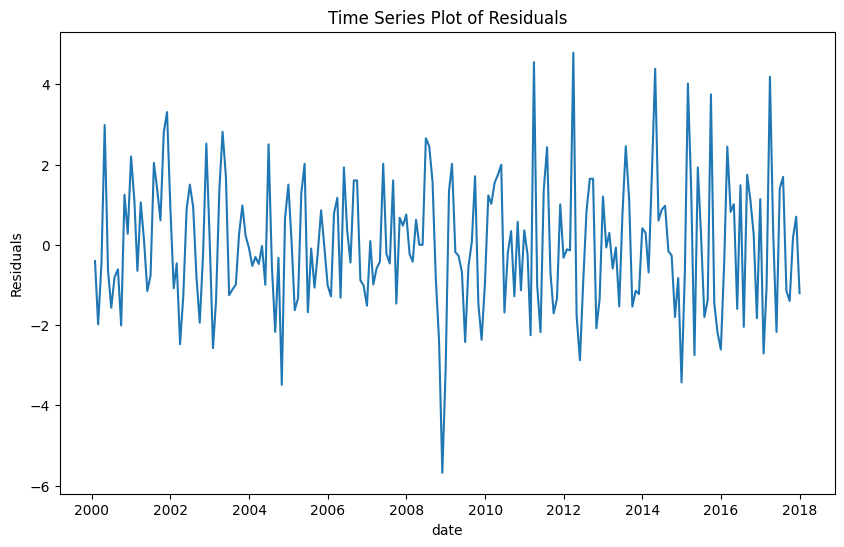

In [16]:
df_post_2000['resid'] = res_3.resid

plt.figure(figsize=(10, 6))
plt.plot(
  df_post_2000['date'],
  df_post_2000['resid']
)
plt.title('Time Series Plot of Residuals')
plt.xlabel('date')
plt.ylabel('Residuals')
plt.show()

## 10.4節の推定

### コクランオーカット推定

In [17]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

glsar_model = sm.GLSAR( # GLSを自己回帰(AR)共分散構造で実装したモデル
    endog,
    exog,
    rho=1 # AR(1)
)
glsar_results = glsar_model.iterative_fit(
    maxiter=2 # 最大反復回数を2回に設定
)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.793
Model:                          GLSAR   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     160.5
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           1.61e-69
Time:                        12:46:20   Log-Likelihood:                -408.22
No. Observations:                 215   AIC:                             828.4
Df Residuals:                     209   BIC:                             848.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0633      0.128      0.493      0.6

In [18]:
rho_iteration_1 = float(glsar_results.model.rho)
print(f'rho Iteration: 1 = {rho_iteration_1}')

rho Iteration: 1 = 0.12383554751602117


コクラン=オーカット推定は以下のOLS推定と同じ

In [19]:
df['rho'] = rho_iteration_1
df['y_lag1'] = df['y'].shift()
df['y_hat'] = df['y'] - df['rho'] * df['y_lag1']
df['x0_hat'] = 1 - df['rho']
df['x1_hat'] = df['x'] - df['rho'] * df['x_lag1']
df['x2_hat'] = df['x_lag1'] - df['rho'] * df['x_lag2']
df['x_lag3'] = df['x'].shift(3)
df['x3_hat'] = df['x_lag2'] - df['rho'] * df['x_lag3']
df['d1_hat'] = df['d1'] - df['rho'] * df['d1'].shift()
df['d2_hat'] = df['d2'] - df['rho'] * df['d2'].shift()

df_post_2000 = df[df['date'] >= '2000-01-01'].copy()

df_post_2000

,date,price,brent,spot,oil,log_price,y,log_oil,x,x_lag1,...,rho,y_lag1,y_hat,x0_hat,x1_hat,x2_hat,x_lag3,x3_hat,d1_hat,d2_hat
151,2000-01-31,63.1,25.51,105.30,2686.2030,4.144721,0.795549,7.895884,2.773968,1.558972,...,0.123836,0.801929,0.696242,0.876164,2.580912,0.340974,-3.279973,10.241784,0.0,0.0
152,2000-02-29,63.3,27.78,109.39,3038.8542,4.147885,0.316456,8.019236,12.335186,2.773968,...,0.123836,0.795549,0.217939,0.876164,11.991671,2.580912,9.835606,0.340974,0.0,0.0
153,2000-03-31,64.3,27.49,106.31,2922.4619,4.163560,1.567430,7.980182,-3.905416,12.335186,...,0.123836,0.316456,1.528242,0.876164,-5.432950,11.991671,1.558972,2.580912,0.0,0.0
154,2000-04-30,64.5,22.76,105.63,2404.1388,4.166665,0.310559,7.784947,-19.523463,-3.905416,...,0.123836,1.567430,0.116456,0.876164,-19.039833,-5.432950,2.773968,11.991671,0.0,0.0
155,2000-05-31,63.5,27.74,108.32,3004.7968,4.151040,-1.562532,8.007965,22.301819,-19.523463,...,0.123836,0.310559,-1.600990,0.876164,24.719518,-19.039833,12.335186,-5.432950,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2017-08-31,96.1,51.70,109.83,5678.2110,4.565389,0.104112,8.644391,4.099830,5.802144,...,0.123836,0.626961,0.026472,0.876164,3.381318,6.964576,-1.924501,-9.148578,0.0,0.0
363,2017-09-30,97.0,56.15,110.78,6220.2970,4.574711,0.932166,8.735573,9.118144,4.099830,...,0.123836,0.104112,0.919273,0.876164,8.610439,3.381318,-9.386900,6.964576,0.0,0.0
364,2017-10-31,99.7,57.51,112.91,6493.4541,4.602166,2.745470,8.778550,4.297695,9.118144,...,0.123836,0.932166,2.630035,0.876164,3.168545,8.610439,5.802144,3.381318,0.0,0.0
365,2017-11-30,102.9,62.71,112.82,7074.9422,4.633758,3.159197,8.864315,8.576467,4.297695,...,0.123836,2.745470,2.819210,0.876164,8.044259,3.168545,4.099830,8.610439,0.0,0.0


In [20]:
endog = df_post_2000['y_hat']
exog = df_post_2000[['x0_hat', 'x1_hat', 'x2_hat', 'x3_hat', 'd1_hat', 'd2_hat']]
mod_6 = sm.OLS(endog, exog).fit()
print(mod_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  y_hat   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     161.2
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           7.36e-70
Time:                        12:46:34   Log-Likelihood:                -409.63
No. Observations:                 216   AIC:                             831.3
Df Residuals:                     210   BIC:                             851.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x0_hat         0.0621      0.128      0.486      0.6

# 追加 繰り返しコクラン=オーカット法

In [21]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

cochran_orcutt_model = sm.GLSAR( # GLSを自己回帰(AR)共分散構造で実装したモデル
    endog,
    exog,
    rho=1 # AR(1)
)
cochran_orcutt_results = cochran_orcutt_model.iterative_fit(
    maxiter=6 # 最大反復回数を6回に設定
)
print(cochran_orcutt_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.793
Model:                          GLSAR   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     159.9
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           2.20e-69
Time:                        12:46:36   Log-Likelihood:                -408.21
No. Observations:                 215   AIC:                             828.4
Df Residuals:                     209   BIC:                             848.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0636      0.130      0.491      0.6

## Prais-Winsten 推定法

1. 初期OLS推定
2. 自己相関係数の推定

$$
u_t = \rho u_{t-1} + \epsilon_t
$$

3. データ変換

- $t = 1$ の場合 (Prais-Winsten特有の変換)

$$
\sqrt{1 - \rho^2}y_1 = \alpha\sqrt{1 - \rho^2} + \beta\sqrt{1 - \rho^2}X_1 + \epsilon_1\sqrt{1 - \rho^2}
$$

- $t = 2, 3, \cdots, T$ の場合

$$
y_t - \rho y_{t-1} = \alpha(1-\rho) + \beta(X_t-\rho X_{t-1}) + \epsilon_t
$$

1. 変換データでのOLS

```r
model_11 <- prais_winsten(
  y ~ x + l1.x + l2.x + d1 + d2,
  data = df2,
  index = df2$date,
  twostep = FALSE
)
summary(model_11)
```

In [37]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

ols_model = sm.OLS(endog, exog).fit()
rho = acf(ols_model.resid, nlags=1)[1]
print(f'rho = {rho:.3f}')

rho = 0.123


In [43]:
def prais_winsten(endog, exog, maxiter=50, tol=1e-8):
    # 1. 初期推定（OLS）
    ols_model = sm.OLS(endog, exog)
    ols_results = ols_model.fit()
    # 自己相関係数の推定
    rho = acf(ols_results.resid, nlags=1)[1]
    print(f'rho = {rho:.3f}')

    # 2-5. 反復プロセス
    for _ in range(maxiter):
        # データの変換
        y_transformed = np.zeros_like(endog)
        X_transformed = np.zeros_like(exog)

        # t = 1 の場合
        y_transformed[0] = np.sqrt(1 - rho**2) * endog.iloc[0]
        X_transformed[0] = np.sqrt(1 - rho**2) * exog.iloc[0]

        # t = 2, 3, ..., T の場合
        y_transformed[1:] = endog.iloc[1:].values - rho * endog.iloc[:-1].values
        X_transformed[1:] = exog.iloc[1:].values - rho * exog.iloc[:-1].values

        # 変換後データでの回帰
        gls_model = sm.OLS(y_transformed, X_transformed)
        gls_results = gls_model.fit()

        # 収束判定
        if np.abs(gls_results.params - ols_results.params).max() < tol:
            break

        ols_results = gls_results
        resid = gls_results.resid

    # 6. 最終推定結果
    return gls_results

In [44]:
endog = df_post_2000['y']
exog = df_post_2000[['x', 'x_lag1', 'x_lag2', 'd1', 'd2']]
exog = sm.add_constant(exog)

# Prais-Winsten推定の実行
pw_results = prais_winsten(endog, exog, maxiter=2)

# 結果の表示
print(pw_results.summary())

rho = 0.123
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.794
Model:                            OLS   Adj. R-squared (uncentered):              0.788
Method:                 Least Squares   F-statistic:                              134.9
Date:                Fri, 27 Sep 2024   Prob (F-statistic):                    3.16e-69
Time:                        12:52:56   Log-Likelihood:                         -409.64
No. Observations:                 216   AIC:                                      831.3
Df Residuals:                     210   BIC:                                      851.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------